# Autoencoders for image denoising
### Results presentation
Authors: Alvils Stūre, Katarzyna Otko, Pawel Pieta

In the project, 2 datasets were used: CIFAR-10 and Dermatological images. The first one is a publicly available dataset, so it is covered by this notebook. Dermatological images were provided by the project owner and can't be shared. Through this notebook it is possible to see the models we used on dermatological data and import their pre-trained parameters, but due to confidentiality, the data itself isn't provided

In [1]:
!git clone https://github.com/Nomow/02456-deep-learning-image-denoising.git
!pip install -U albumentations
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

fatal: destination path '02456-deep-learning-image-denoising' already exists and is not an empty directory.
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-wfjgc166
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-wfjgc166


In [2]:
# CIFAR10 download
!cd ..
!mkdir data
!cd data
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

mkdir: cannot create directory ‘data’: File exists
--2021-12-23 16:26:00--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  50.2MB/s    in 3.6s    

2021-12-23 16:26:04 (44.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
%cd /content/02456-deep-learning-image-denoising
import numpy as np
import glob
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torch.optim as optim
from IPython.display import clear_output

import segmentation_models_pytorch as smp
from dataset import AutoEncoderDataset
from utils import train
from utils import val
import data
import dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

/content/02456-deep-learning-image-denoising


In [4]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [5]:
# https://drive.google.com/file/d/18kzUXkWZ8j8hbewhnnrPtbLGAYNekEwv/view?usp=sharing
%cd /content


from skimage.io import imread
import os
if not os.path.exists('./models'):
    %mkdir models
    %cd models
    import gdown
    url = 'https://drive.google.com/uc?id=18kzUXkWZ8j8hbewhnnrPtbLGAYNekEwv'
    gdown.download(url, './models.zip', quiet=False)
    !unzip ./models.zip > /dev/null
%cd /content

/content
/content


In [6]:
from pathlib import Path

root_path = Path('/content/models') 

# CIFAR-10

In [7]:
def denormalize(img):
  image = np.swapaxes(np.swapaxes(img.numpy(), 0, 2), 0, 1)
  MEAN = 255 * np.array([0.5, 0.5, 0.5])
  STD = 255 * np.array([0.5, 0.5, 0.5])
  image = ((image * STD)+ MEAN).astype(int)
  return image

## Preparing data loaders

In [8]:
train_data, test_data = data.load_cifar_10_data("cifar-10-batches-py")

batch_size = 64

transform = A.Compose([
    A.Blur(blur_limit=4, always_apply=False, p=0.8),
    A.MultiplicativeNoise(multiplier=(0.7, 1.3), p=0.8),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.4, brightness_by_max=True, always_apply=False, p=0.8),
    A.ISONoise(color_shift=(0.08, 0.15), intensity=(0.2, 0.3), always_apply=False, p=0.8),
    A.RandomToneCurve(scale=0.3, p=0.8)
])

preprocess_transform = A.Compose([
    A.Normalize(mean = [0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
    
    ])



trainset = dataset.Cifar10AutoEncoderDataset(train_data, preprocess_transform, transform)
train_loader_cifar = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = dataset.Cifar10AutoEncoderDataset(test_data, preprocess_transform, transform)
test_loader_cifar = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1)

Dataset presentation

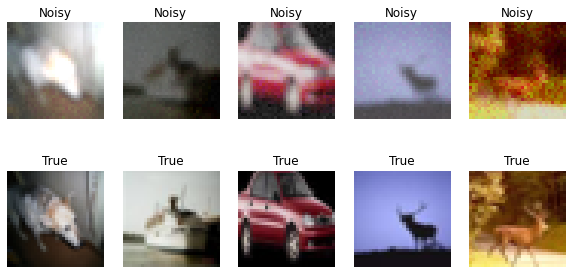

In [9]:
images, labels = next(iter(train_loader_cifar))
plt.figure(figsize=(10,5))


for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(denormalize(images[i]))
    plt.axis('off')
    plt.title("Noisy")

for i in range(5):
    plt.subplot(2,5,i+6)
    plt.imshow(denormalize(labels[i]))
    plt.axis('off')
    plt.title("True")

## Model definition

Baseline model

In [10]:
class AutoEncoderLeakyReLUShallow(nn.Module):
    def __init__(self, hidden_units1, hidden_units2,latent_features=2):
        super(AutoEncoderLeakyReLUShallow, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=3072, out_features=hidden_units1),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.LeakyReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units2, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units2),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units1, out_features=3072)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        # apply sigmoid to output to get pixel intensities between 0 and 1
        x_hat = torch.tanh(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }

Convolutional autoencoder

In [11]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc_batchnorm_0 = nn.BatchNorm2d(32)
        self.dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 32 -> 16
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_batchnorm_1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 16 -> 8
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_batchnorm_2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 8 -> 4

        # bottleneck
        self.bottleneck_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(64, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128,128,2,stride=2)   # 64 -> 128
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_batchnorm_0 = nn.BatchNorm2d(64)
        self.dec_dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)   # 128 -> 256
        self.dec_conv1 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_batchnorm_1 = nn.BatchNorm2d(32)
        self.dec_dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample2 = nn.ConvTranspose2d(32,32,2,stride=2)   # 256 -> 512
        self.dec_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.dec_batchnorm_2 = nn.BatchNorm2d(32)
        self.dec_dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)


    def forward(self, x): 
        # encoder
        e0 = self.dropout0(F.leaky_relu(self.enc_batchnorm_0(self.enc_conv0(x))))
        e1 = self.dropout1(F.leaky_relu(self.enc_batchnorm_1(self.enc_conv1(self.pool0(e0)))))
        e2 = self.dropout2(F.leaky_relu(self.enc_batchnorm_2(self.enc_conv2(self.pool1(e1)))))

        # bottleneck
        b = F.leaky_relu(self.bottleneck_conv2(F.leaky_relu(self.bottleneck_conv1(self.pool2(e2)))))
       
        # decoder
        d0 = self.dec_dropout0(F.leaky_relu(self.dec_batchnorm_0(self.dec_conv0(self.upsample0(b)))))
        d1 = self.dec_dropout1(F.leaky_relu(self.dec_batchnorm_1(self.dec_conv1(self.upsample1(d0)))))
        d2 = self.dec_dropout2(F.leaky_relu(self.dec_batchnorm_2(self.dec_conv2(self.upsample2(d1)))))
        out = F.tanh(self.dec_conv_fin(d2))
        return out

Convolutional autoencoder with skip connections

In [12]:
class ConvAutoEncoderSkip(nn.Module):
    def __init__(self):
        super(ConvAutoEncoderSkip, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc_batchnorm_0 = nn.BatchNorm2d(32)
        self.dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 32 -> 16
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_batchnorm_1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 16 -> 8
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_batchnorm_2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 8 -> 4

        # bottleneck
        self.bottleneck_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(64, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128,128,2,stride=2)  # 4 -> 8
        self.dec_conv0 = nn.Conv2d(256, 64, 3, padding=1)
        self.dec_batchnorm_0 = nn.BatchNorm2d(64)
        self.dec_dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)   # 8 -> 16
        self.dec_conv1 = nn.Conv2d(128, 32, 3, padding=1)
        self.dec_batchnorm_1 = nn.BatchNorm2d(32)
        self.dec_dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample2 = nn.ConvTranspose2d(32,32,2,stride=2)   # 16 -> 32
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_batchnorm_2 = nn.BatchNorm2d(32)
        self.dec_dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)


    def forward(self, x): 
        # encoder
        e0 = self.dropout0(F.leaky_relu(self.enc_batchnorm_0(self.enc_conv0(x))))
        e1 = self.dropout1(F.leaky_relu(self.enc_batchnorm_1(self.enc_conv1(self.pool0(e0)))))
        e2 = self.dropout2(F.leaky_relu(self.enc_batchnorm_2(self.enc_conv2(self.pool1(e1)))))

        # bottleneck
        b = F.leaky_relu(self.bottleneck_conv2(F.leaky_relu(self.bottleneck_conv1(self.pool2(e2)))))
       
        # decoder
        d0 = self.dec_dropout0(F.leaky_relu(self.dec_batchnorm_0(self.dec_conv0(torch.cat([self.upsample0(b), e2], 1)))))
        d1 = self.dec_dropout1(F.leaky_relu(self.dec_batchnorm_1(self.dec_conv1(torch.cat([self.upsample1(d0), e1], 1)))))
        d2 = self.dec_dropout2(F.leaky_relu(self.dec_batchnorm_2(self.dec_conv2(torch.cat([self.upsample2(d1), e0], 1)))))
        out = F.tanh(self.dec_conv_fin(d2))
        return out

### Load model weights

In [13]:
baseline = AutoEncoderLeakyReLUShallow(hidden_units1=1024, hidden_units2=512, latent_features=100).to(device)
conv = ConvAutoEncoder().to(device)
conv_skip = ConvAutoEncoderSkip().to(device)

save_path_cifar_baseline = root_path / "CIFAR_baseline"
save_path_cifar_conv = root_path / "CIFAR_conv"
save_path_cifar_conv_skip = root_path / "CIFAR_conv_skip"

baseline.load_state_dict(torch.load(os.path.join(save_path_cifar_baseline, "best.pth")))
conv.load_state_dict(torch.load(os.path.join(save_path_cifar_conv, "best.pth")))
conv_skip.load_state_dict(torch.load(os.path.join(save_path_cifar_conv_skip, "best.pth")))

<All keys matched successfully>

## CIFAR-10 results

Visual image comparison

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


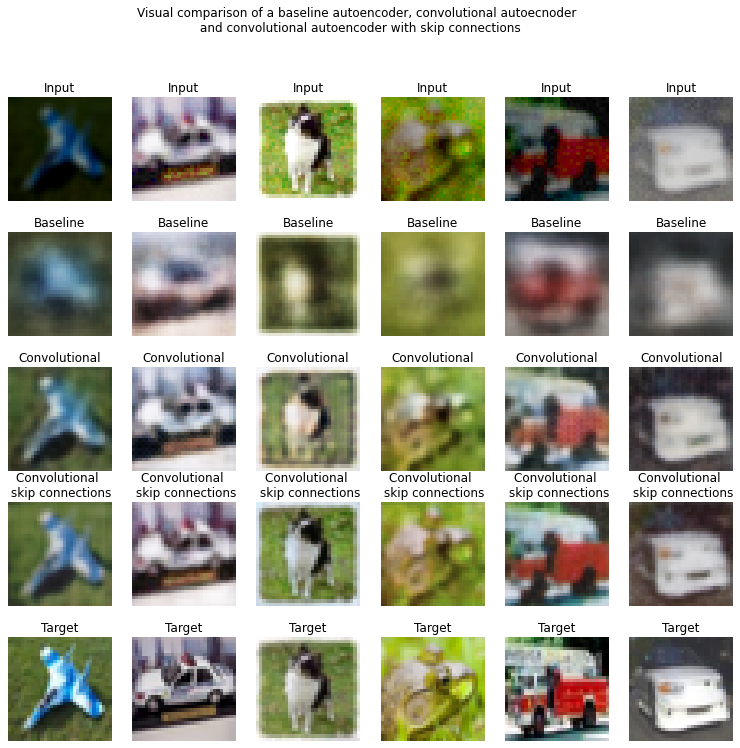

In [14]:
X_val, Y_val = next(iter(test_loader_cifar))

baseline_x_in = torch.reshape(X_val, (X_val.shape[0], -1))
baseline_out = baseline(baseline_x_in.to(device))
baseline_out = baseline_out['x_hat'].detach().cpu().reshape((64, 3, 32, 32))
conv_out = conv(X_val.to(device)).detach().cpu()
conv_skip_out = conv_skip(X_val.to(device)).detach().cpu()


k = 0
fig = plt.figure(figsize=(13,12))
for m in range(6):
  plt.subplot(5, 6, k+1)
  plt.imshow(denormalize(X_val[m]))
  plt.title('Input')
  plt.axis('off')

  plt.subplot(5, 6, k+7)
  plt.imshow(denormalize(baseline_out[m]))
  plt.title('Baseline')
  plt.axis('off')

  plt.subplot(5, 6, k+13)
  plt.imshow(denormalize(conv_out[m]))
  plt.title('Convolutional')
  plt.axis('off')

  plt.subplot(5, 6, k+19)
  plt.imshow(denormalize(conv_skip_out[m]))
  plt.title('Convolutional \n skip connections')
  plt.axis('off')

  plt.subplot(5, 6, k+25)
  plt.imshow(denormalize(Y_val[m]))
  plt.title('Target')
  plt.axis('off')
  
  k+=1
plt.suptitle('Visual comparison of a baseline autoencoder, convolutional autoecnoder \n and convolutional autoencoder with skip connections')
plt.show()

Training loss function comparison

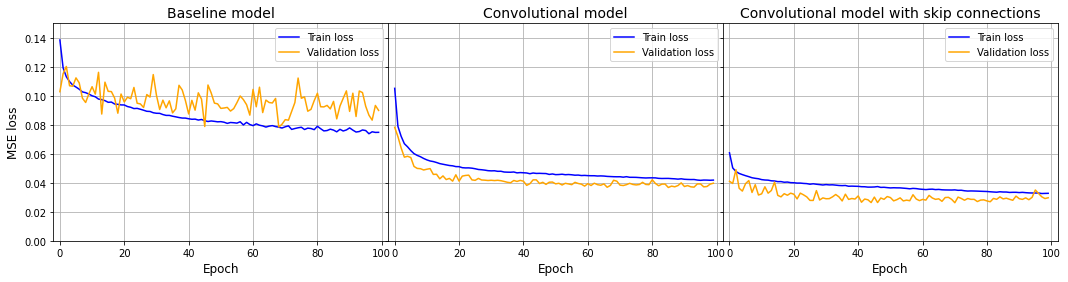

In [15]:
baseline_logs = np.load(os.path.join(save_path_cifar_baseline, "logs.npy"),allow_pickle=True).tolist()
conv_logs = np.load(os.path.join(save_path_cifar_conv, "logs.npy"),allow_pickle=True).tolist()
conv_skip_logs = np.load(os.path.join(save_path_cifar_conv_skip, "logs.npy"),allow_pickle=True).tolist()

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, gridspec_kw={'wspace': 0},figsize=(18,4))
plt.ylim((0,0.15))
plt.xlim((-2,102))

axs[0].plot(baseline_logs['train'], 'b', label = "Train loss")
axs[0].plot(baseline_logs['val'], 'orange', label = "Validation loss")
axs[0].set_xlabel("Epoch", fontsize = 12); axs[0].set_ylabel("MSE loss", fontsize = 12); 
axs[0].set_title("Baseline model", fontsize = 14);

axs[0].grid('on')
axs[0].legend();


axs[1].plot(conv_logs['train'], 'b', label = "Train loss")
axs[1].plot(conv_logs['val'], 'orange', label = "Validation loss")
axs[1].set_xlabel("Epoch", fontsize = 12);
axs[1].set_title("Convolutional model", fontsize = 14); 
axs[1].grid('on')
axs[1].legend();


axs[2].plot(conv_skip_logs['train'], 'b', label = "Train loss")
axs[2].plot(conv_skip_logs['val'], 'orange', label = "Validation loss")
axs[2].set_title("Convolutional model with skip connections", fontsize = 14); 
axs[2].set_xlabel("Epoch", fontsize = 12);
axs[2].grid('on')
axs[2].legend();

# Dermatological dataset
**This part of the result presentation doesn't use the dataset due to confidentiality** Only a presentation of the networks and training loss function is provided.


In [16]:
def denormalize(img):
  image = np.swapaxes(np.swapaxes(img.numpy(), 0, 2), 0, 1)
  MEAN = 255 * np.array([0.485, 0.456, 0.406])
  STD = 255 * np.array([0.229, 0.224, 0.225])
  image = ((image * STD)+ MEAN).astype(int)
  return image[...,::-1] #bgr to rgb

## Preparing data loaders

In [18]:
img_max_size = 512
batch_size=15

train_transform = [
    A.Blur(blur_limit=20, always_apply=False, p=0.6),
    A.MultiplicativeNoise(multiplier=(0.7, 1.3), p=0.6),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.4, brightness_by_max=True, always_apply=False, p=0.6),
    A.Downscale(scale_min=0.25, scale_max=0.25, interpolation=0, always_apply=False, p=0.3),
    A.ISONoise(color_shift=(0.08, 0.15), intensity=(0.2, 0.3), always_apply=False, p=0.6),
    A.RandomToneCurve(scale=0.3, p=0.6)
    ]

train_transforms = A.Compose(train_transform)

preprocess_transform = [
    A.LongestMaxSize(max_size=img_max_size, always_apply=True),
    A.PadIfNeeded(min_height=img_max_size, min_width=img_max_size, always_apply=True, border_mode=0),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()]

preprocess_transforms = A.Compose(preprocess_transform)

# train_dataset = AutoEncoderDataset(train_path, preprocess_transforms, train_transforms)
# val_dataset = AutoEncoderDataset(val_path, preprocess_transforms, train_transforms)
# test_dataset = AutoEncoderDataset(test_path, preprocess_transforms)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


## Model definition

Convolutional autoencoder

In [19]:
class ConvAutoEncoderDerm(nn.Module):
    def __init__(self):
        super(ConvAutoEncoderDerm, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc_batchnorm_0 = nn.BatchNorm2d(32)
        self.dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 512 -> 256
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_batchnorm_1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 256 -> 128
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_batchnorm_2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 128 -> 64
        self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_batchnorm_3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool3 = nn.Conv2d(256, 256,2, padding=0, stride=2)  # 64 -> 32

        # bottleneck
        self.bottleneck_conv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(128, 256, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256,256,2,stride=2)  # 32 -> 64
        self.dec_conv0 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec_batchnorm_0 = nn.BatchNorm2d(128)
        self.dec_dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample1 = nn.ConvTranspose2d(128,128,2,stride=2)   # 64 -> 128
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_batchnorm_1 = nn.BatchNorm2d(64)
        self.dec_dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample2 = nn.ConvTranspose2d(64,64,2,stride=2)   # 128 -> 256
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_batchnorm_2 = nn.BatchNorm2d(32)
        self.dec_dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample3 = nn.ConvTranspose2d(32,32,2,stride=2)   # 256 -> 512
        self.dec_conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.dec_batchnorm_3 = nn.BatchNorm2d(32)
        self.dec_dropout3 = nn.Dropout2d(p=0.1, inplace=False)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)


    def forward(self, x): 
        # encoder
        e0 = self.dropout0(F.leaky_relu(self.enc_batchnorm_0(self.enc_conv0(x))))
        e1 = self.dropout1(F.leaky_relu(self.enc_batchnorm_1(self.enc_conv1(self.pool0(e0)))))
        e2 = self.dropout2(F.leaky_relu(self.enc_batchnorm_2(self.enc_conv2(self.pool1(e1)))))
        e3 = self.dropout3(F.leaky_relu(self.enc_batchnorm_3(self.enc_conv3(self.pool2(e2)))))

        # bottleneck
        b = F.leaky_relu(self.bottleneck_conv2(F.leaky_relu(self.bottleneck_conv1(self.pool3(e3)))))
       
        # decoder
        d0 = self.dec_dropout0(F.leaky_relu(self.dec_batchnorm_0(self.dec_conv0(self.upsample0(b)))))
        d1 = self.dec_dropout1(F.leaky_relu(self.dec_batchnorm_1(self.dec_conv1(self.upsample1(d0)))))
        d2 = self.dec_dropout2(F.leaky_relu(self.dec_batchnorm_2(self.dec_conv2(self.upsample2(d1)))))
        d3 = self.dec_dropout3(F.leaky_relu(self.dec_batchnorm_3(self.dec_conv3(self.upsample3(d2)))))
        out = F.tanh(self.dec_conv_fin(d3))
        return out

U-net

In [20]:
architecture = smp.Unet
encoder = 'timm-regnetx_016'
weight_path = os.path.join("/content/weights", encoder + "-" + architecture.__name__)


unet = architecture(encoder_name=encoder,  # UnetPlusPlus
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=3,
    )

U-Net++

In [21]:
architecture = smp.UnetPlusPlus
encoder = 'timm-regnetx_016'
weight_path = os.path.join("/content/weights", encoder + "-" + architecture.__name__)


unetpp = architecture(encoder_name=encoder,  # UnetPlusPlus
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=3,
    )

### Load model weights

In [22]:
save_path_autoencoder = root_path / "conv_autoencoder"
autoencoder = ConvAutoEncoderDerm().to(device)
autoencoder.load_state_dict(torch.load(os.path.join(save_path_autoencoder, "best.pth")))

save_path_unet = root_path / "experiment_unet"
unet.load_state_dict(torch.load(os.path.join(save_path_unet, "best.pth")))
unet = unet.to(device)

save_path_unetpp = root_path / "experiment_unetplusplus"
unetpp.load_state_dict(torch.load(os.path.join(save_path_unetpp, "best.pth")))
unetpp = unetpp.to(device)

## Dermatological dataset results


Training loss function comparison

In [23]:
autoenc_logs = np.load(os.path.join(save_path_autoencoder, "logs.npy"),allow_pickle=True).tolist()
unet_logs = np.load(os.path.join(save_path_unet, "logs.npy"),allow_pickle=True).tolist()
unetpp_logs = np.load(os.path.join(save_path_unetpp, "logs.npy"),allow_pickle=True).tolist()

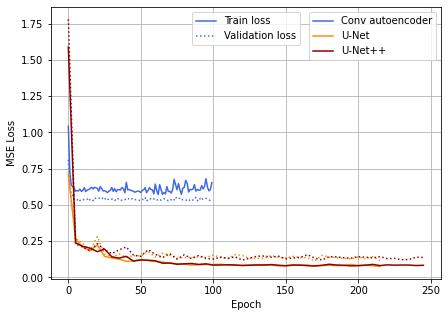

In [24]:
unet_val_ep = [ unet_logs['val'][i]['epoch'] for i in range(len(unet_logs['val'])) ]
unet_val_loss = [ unet_logs['val'][i]['loss'] for i in range(len(unet_logs['val'])) ]

unet_train_ep = [ unet_logs['train'][i]['epoch'] for i in range(len(unet_logs['train'])) ]
unet_train_loss = [ unet_logs['train'][i]['loss'] for i in range(len(unet_logs['train'])) ]

unetpp_val_ep = [ unetpp_logs['val'][i]['epoch'] for i in range(len(unetpp_logs['val'])) ]
unetpp_val_loss = [ unetpp_logs['val'][i]['loss'] for i in range(len(unetpp_logs['val'])) ]

unetpp_train_ep = [ unetpp_logs['train'][i]['epoch'] for i in range(len(unetpp_logs['train'])) ]
unetpp_train_loss = [ unetpp_logs['train'][i]['loss'] for i in range(len(unetpp_logs['train'])) ]

plt.figure(figsize=(7,5))
l1_1, = plt.plot(autoenc_logs['train'], 'royalblue', label = "Train loss")
l1_2, = plt.plot(autoenc_logs['val'], 'royalblue', linestyle='dotted', label = "Validation loss")

l2_1, = plt.plot(unet_train_ep, unet_train_loss, 'darkorange', label = "Train loss")
l2_2, = plt.plot(unet_val_ep, unet_val_loss, 'darkorange', linestyle='dotted', label = "Validation loss")

l3_1, = plt.plot(unetpp_train_ep, unetpp_train_loss, 'darkred', label = "Train loss")
l3_2, = plt.plot(unetpp_val_ep, unetpp_val_loss, 'darkred',linestyle='dotted', label = "Validation loss")

plt.grid('on')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

legend1 = plt.legend([l1_1, l1_2], ["Train loss", "Validation loss"], loc=9)
plt.legend([l1_1,l2_1,l3_1], ["Conv autoencoder", "U-Net", "U-Net++"])
plt.gca().add_artist(legend1)